## Import Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)

In [3]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Import Data

In [4]:
df_train = pd.read_csv('./fashion-mnist_train.csv')
# df_test = pd.read_csv('./fashion-mnist_test.csv')
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df_train.shape

(60000, 785)

## Image Plotting

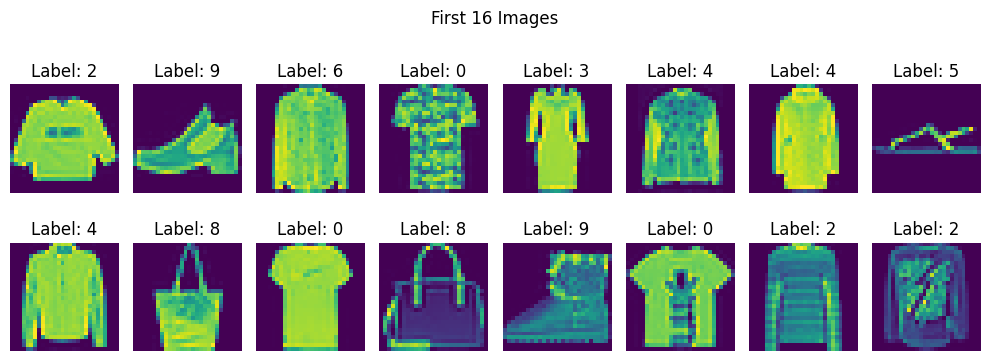

In [6]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(2, 8, figsize=(10,4))
fig.suptitle("First 16 Images")

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
  img = df_train.iloc[i, 1:].values.reshape(28, 28)           # Reshape to 28x28
  ax.imshow(img)                                        # Display in grayscale 
  ax.axis('off')                                        # Remove axis for a cleaner look
  ax.set_title(f"Label: {df_train.iloc[i, 0]}")               # Show the label

plt.tight_layout(rect=[0, 0, 1, 1])                  # Adjust layout to fit the title
plt.show()   

## Data Processing

In [7]:
# features, label split
def df_split(df):
  x = df.iloc[:, 1:].values
  y = df.iloc[:, 0].values
  return x, y

In [8]:
X, y = df_split(df_train)
# X_test, y_test = df_split(df_test)

X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(60000, 784))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)

In [10]:
from torchvision import transforms

# Define data augmentations for the training dataset
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

## DataLoader

In [11]:
# Create CustomDataset Class
class CustomDataset(Dataset):

  def __init__(self, features, labels, transform=None):
    self.features = torch.tensor(features, dtype=torch.float32).reshape(-1, 1, 28, 28)
    self.labels = torch.tensor(labels, dtype=torch.long)
    self.transform = transform

  def __len__(self):
    return len(self.features)
  
  def __getitem__(self, idx):
    feature, label = self.features[idx], self.labels[idx]
    if self.transform:
      feature = self.transform(feature.squeeze(0).numpy())  # Apply transform
    return feature, label

In [12]:
# Use augmentations in training data
train_dataset = CustomDataset(X_train, y_train, transform=train_transform)
# val_dataset = CustomDataset(X_val, y_val, transform=test_transform)
test_dataset = CustomDataset(X_test, y_test, transform=test_transform)

In [13]:
train_dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.7765, 0.4706, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9765, 0.7882, 0.6902,
           0.5804, 0.4118, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9765, 0.9961, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [14]:
len(test_dataset)

12000

## Model Definition

In [15]:
channels = 1                         # Grayscale images have 1 input channel

In [16]:
# Model Definiton for HPT
class DynamicCNN(nn.Module):

  def __init__(self, img_dim, output_dim, num_conv_layers, num_filters, kernel_size, num_fc_layers, fc_layer_size, dropout_rate):
    super().__init__()
    layers = []
    in_channel = channels     

    # Feature Extraction (Convulation) layers
    for _ in range(num_conv_layers):
      layers+= [
        nn.Conv2d(in_channel, num_filters, kernel_size, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(num_filters),
        nn.MaxPool2d(kernel_size=2, stride=2),
      ]
      in_channel = num_filters            # Update input channels for the next layer
    self.features = nn.Sequential(*layers)

    # Classifier (Fully connected) layers
    fc_layers = [nn.Flatten()]
    input_size = num_filters * (img_dim // (2 ** num_conv_layers))**2
    for _ in range(num_fc_layers):
      fc_layers += [
        nn.Linear(input_size, fc_layer_size),
        nn.Dropout(p=dropout_rate),
        nn.ReLU(),
      ]
      input_size = fc_layer_size
      
    fc_layers.append(nn.Linear(input_size, output_dim))

    self.classifier = nn.Sequential(*fc_layers)

  def forward(self, x):
    x = self.features(x)
    x = self.classifier(x)
    return x

## Optuna Hyperparameter Tuning

In [17]:
# Pipeline variables

img_dim = 28
output_dim = 10

optimizer_map = {
  "Adam": optim.Adam,
  "SGD": optim.SGD,
  "RMSprop": optim.RMSprop,
}

loss_fn = nn.CrossEntropyLoss()

pin = (device.type == "cuda")

In [18]:
# Final Training
def training(epochs, model, loader, optimizer): 
  model.train()
  for _ in range(epochs):
    for batch_features,batch_labels in loader:
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)     # Move batch data to gpu      
      outputs = model(batch_features)                                                       # forward pass
      loss = loss_fn(outputs, batch_labels)                                                 # calculate loss
      optimizer.zero_grad()                                                                 # backward pass - zero grad
      loss.backward()                                                                       # backward pass 
      optimizer.step()                                                                      # update parameters

In [19]:
# evaluation code
def accuracy(model, loader):
  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for batch_features,batch_labels in loader:      
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)      # Move batch data to gpu
      outputs = model(batch_features)
      _, predicted = torch.max(outputs, 1)
      total += batch_labels.shape[0]
      correct += (predicted==batch_labels).sum().item()
    accuracy = correct/total
  return accuracy

In [20]:
# Objective Function
def objective(trial):

  # next hyperparameter values from the search space
  num_conv_layers = trial.suggest_int("num_conv_layers", 1, 3)
  num_filters = trial.suggest_categorical("num_filters", [16, 32, 64, 128])
  kernel_size = trial.suggest_categorical("kernel_size", [3, 5])
  num_fc_layers = trial.suggest_int("num_fc_layers", 1, 3)
  fc_layer_size = trial.suggest_categorical("fc_layer_size", [64, 128, 256])
  epochs = trial.suggest_int("epochs", 10, 50, step=10)
  learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
  batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
  optimizer_name = trial.suggest_categorical("optimizer_name", ['Adam', 'SGD', 'RMSprop'])  
  weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)

  # Create train and test loader
  train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=pin)
  test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=4, pin_memory=pin)
  # val_loader = DataLoader(val_dataset, batch_size, num_workers=4, shuffle=False, pin_memory=True)

  # Model
  model = DynamicCNN(img_dim, output_dim, num_conv_layers, num_filters, kernel_size, num_fc_layers, fc_layer_size, dropout_rate)
  model = model.to(device)

  # optimizer init
  optimizer = optimizer_map[optimizer_name](model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  # training loop
  training(epochs, model, train_loader, optimizer)

  # evaluation
  return accuracy(model, test_loader)                                    # ideally should be val_loader

In [21]:
import optuna

pruner = optuna.pruners.MedianPruner()
study = optuna.create_study(direction='maximize', pruner=pruner)

/home/dhruv-kapri/Desktop/Projects/Pytorch/5 - CNN/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-12-21 12:51:42,520] A new study created in memory with name: no-name-3a1e9c9f-e58f-4394-a5da-1680f5e58bd2


In [22]:
study.optimize(func=objective, n_trials=10, n_jobs=1)

[I 2025-12-21 12:59:32,742] Trial 0 finished with value: 0.9229166666666667 and parameters: {'num_conv_layers': 2, 'num_filters': 128, 'kernel_size': 3, 'num_fc_layers': 3, 'fc_layer_size': 256, 'epochs': 50, 'learning_rate': 0.00028861080901429584, 'dropout_rate': 0.5, 'batch_size': 64, 'optimizer_name': 'Adam', 'weight_decay': 0.00017182615544326728}. Best is trial 0 with value: 0.9229166666666667.
[I 2025-12-21 13:03:46,854] Trial 1 finished with value: 0.8688333333333333 and parameters: {'num_conv_layers': 1, 'num_filters': 64, 'kernel_size': 3, 'num_fc_layers': 3, 'fc_layer_size': 256, 'epochs': 30, 'learning_rate': 0.0010842415790703645, 'dropout_rate': 0.2, 'batch_size': 32, 'optimizer_name': 'SGD', 'weight_decay': 0.0031489828743089896}. Best is trial 0 with value: 0.9229166666666667.
[I 2025-12-21 13:05:24,079] Trial 2 finished with value: 0.91225 and parameters: {'num_conv_layers': 3, 'num_filters': 128, 'kernel_size': 3, 'num_fc_layers': 1, 'fc_layer_size': 64, 'epochs': 10,

In [23]:
print(f'best value: {study.best_value}')
print(f'best parameters: {study.best_params}')

best value: 0.9229166666666667
best parameters: {'num_conv_layers': 2, 'num_filters': 128, 'kernel_size': 3, 'num_fc_layers': 3, 'fc_layer_size': 256, 'epochs': 50, 'learning_rate': 0.00028861080901429584, 'dropout_rate': 0.5, 'batch_size': 64, 'optimizer_name': 'Adam', 'weight_decay': 0.00017182615544326728}


## Training Pipeline

In [24]:
# Optuna Results
best_params = study.best_params

# Parameters
epochs = best_params['epochs']
batch_size = best_params['batch_size']
learning_rate = best_params['learning_rate']
weight_decay = best_params['weight_decay']

# Create train and test loader
train_loader = DataLoader(train_dataset, batch_size, num_workers=4, shuffle=True, pin_memory=pin)
# val_loader = DataLoader(val_dataset, batch_size, num_workers=4, shuffle=False, pin_memory=pin)
test_loader = DataLoader(test_dataset, batch_size, num_workers=4, shuffle=False, pin_memory=pin)

# model init
final_model = DynamicCNN(
    img_dim,
    output_dim, 
    num_conv_layers = best_params['num_conv_layers'],
    num_filters = best_params['num_filters'], 
    kernel_size = best_params['kernel_size'], 
    num_fc_layers = best_params['num_fc_layers'], 
    fc_layer_size = best_params['fc_layer_size'], 
    dropout_rate = best_params['dropout_rate']
).to(device)

optimizer = optimizer_map[best_params['optimizer_name']](
    params = final_model.parameters(), 
    lr = learning_rate, 
    weight_decay = weight_decay
)

In [25]:
training(epochs, final_model, train_loader, optimizer)

## Evaluation

In [26]:
# print(f'validation accuracy: {accuracy(final_model, val_loader)}')
print(f'test accuracy: {accuracy(final_model, test_loader)}')
print(f'train accuracy: {accuracy(final_model, train_loader)}')

test accuracy: 0.91925
train accuracy: 0.9194791666666666


## Summary

In [27]:
from torchinfo import summary

summary(final_model, input_size=(1, channels, img_dim, img_dim))    # input size parameter

Layer (type:depth-idx)                   Output Shape              Param #
DynamicCNN                               [1, 10]                   --
├─Sequential: 1-1                        [1, 128, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 128, 28, 28]          1,280
│    └─ReLU: 2-2                         [1, 128, 28, 28]          --
│    └─BatchNorm2d: 2-3                  [1, 128, 28, 28]          256
│    └─MaxPool2d: 2-4                    [1, 128, 14, 14]          --
│    └─Conv2d: 2-5                       [1, 128, 14, 14]          147,584
│    └─ReLU: 2-6                         [1, 128, 14, 14]          --
│    └─BatchNorm2d: 2-7                  [1, 128, 14, 14]          256
│    └─MaxPool2d: 2-8                    [1, 128, 7, 7]            --
├─Sequential: 1-2                        [1, 10]                   --
│    └─Flatten: 2-9                      [1, 6272]                 --
│    └─Linear: 2-10                      [1, 256]                  1,605,88